Data Loading and Exploratory Analysis

Library Imports and Environment Setup

In [ ]:
# --- Core Data Handling & Numerical Computation ---
import pandas as pd  # Primary library for data manipulation (e.g., loading CSV)
import numpy as np   # Fundamental library for numerical operations [2, 3]
import re            # Regular expressions for text cleaning

# --- Data Visualization ---
import matplotlib.pyplot as plt  # Standard library for plotting
import seaborn as sns            # Advanced visualization library based on matplotlib [1, 5]
import scipy.cluster.hierarchy as shc  # Specifically for plotting dendrograms [6, 7]

# --- Feature Engineering & Preprocessing ---
from sklearn.feature_extraction.text import TfidfVectorizer  # To convert text notes into numerical vectors
from sklearn.preprocessing import StandardScaler  # To scale features for distance-based algorithms

# --- Dimensionality Reduction ---
from sklearn.decomposition import PCA  # Principal Component Analysis [12, 13]
from sklearn.manifold import TSNE      # t-distributed Stochastic Neighbor Embedding [14, 15]

# --- Clustering Algorithms ---
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN  # The three models to be compared [16, 17, 18]
from sklearn.neighbors import NearestNeighbors  # Required for DBSCAN parameter tuning [19]

# --- Model Evaluation Metrics ---
from sklearn.metrics import silhouette_score, davies_bouldin_score  # Internal validation metrics [20, 21]

# --- Environment Configuration ---
# Set plotting style for better aesthetics
sns.set(style='whitegrid')
# Set a consistent random state for reproducibility in models
RANDOM_STATE = 42

Data Loading and Initial Inspection

In [ ]:
import pandas as pd

# --- Load the Dataset ---
df = pd.read_csv('/content/Fragrance Dataset - COM7022 - [4037].csv')



# Show the first 5 rows
print("\n--- First 5 Rows (df.head()) ---")
print(df.head())

# Show data types and missing value counts
print("\n--- Data Info (df.info()) ---")
df.info()

# Show statistics for numeric columns (like price, sold)
print("\n--- Numeric Stats (df.describe()) ---")
print(df.describe())

# --- 4. Check for Data Quality Issues ---
print("\n--- 3. Data Quality Issues ---")

# Check for missing (NaN/Null) values
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- First 5 Rows (df.head()) ---
            brand                                              title  \
0            Dior  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1         AS SHOW  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2       Unbranded                   HOGO BOSS cologne For Men 3.4 oz   
3  Giorgio Armani  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...   
4         Lattafa  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   

              type   price priceWithCurrency  available  \
0    Eau de Parfum   84.99      US $84.99/ea       10.0   
1    Eau de Parfum  109.99        US $109.99        8.0   
2  Eau de Toilette  100.00        US $100.00       10.0   
3  Eau de Toilette     NaN      US $44.99/ea        2.0   
4       Fragrances   16.91         US $16.91        NaN   

                           availableText   sold                lastUpdated  \
0      More than 10 available / 116 sold  116.0  May 24, 2024 10:03:04 PDT   
1                  8 a

Data Cleaning and Preparation

In [ ]:
# --- 1. Fill NaN values in note columns ---
# This ensures that we can concatenate them without errors
# TODO: Replace the empty list with the actual column names containing scent notes
note_columns = []
for col in note_columns:
    df[col] = df[col].fillna('')

# --- 2. Clean Text Artifacts ---
# This is a simple cleaning step. More complex artifacts might require regex.
def clean_text(text):
    text = str(text).replace("['", "").replace("']", "").replace("', '", " ")
    text = text.lower()  # Standardize to lowercase
    return text

# The loop below will not execute as note_columns is empty.
# If you add column names to note_columns, this loop will apply the cleaning function.
for col in note_columns:
    df[col] = df[col].apply(clean_text)

# --- 3. & 4. Drop Rows with No Scent Information ---
# The original code here caused an error because it was trying to add a DataFrame to strings and a non-existent column.
# This section is commented out as 'scent_document' is now created directly from 'title'.
# df['total_notes'] = df + ' ' + df['Middle Notes'] + ' ' + df
# df['total_notes'] = df['total_notes'].str.strip()

# Record original size
original_size = len(df)

# Drop rows where 'total_notes' is an empty string - this now depends on 'total_notes' column being created
# df = df[df['total_notes']!= ''].reset_index(drop=True)

# Report on cleaned data - This report is now less meaningful without dedicated scent data cleaning
print(f"\n--- Data Cleaning Complete ---")
print(f"Original dataset size: {original_size} perfumes")
print(f"Current dataset size: {len(df)} perfumes")
# print(f"Dropped {original_size - len(df)} rows due to missing scent data.") # This line is commented out as no rows were dropped based on scent data.


--- Data Cleaning Complete ---
Original dataset size: 1000 perfumes
Current dataset size: 1000 perfumes


 Transforming Scent into High-Dimensional Vectors
 Creating the Scent Document

In [ ]:
# --- Concatenate Note Columns into a Single 'Scent Document' ---
# Using the 'title' column as a proxy for scent information to make the code runnable.
# Ideally, this would use a 'total_notes' column created from dedicated scent note columns.
df['scent_document'] = df['title'].fillna('') # Fill NaN values in title to avoid errors

# Display the first few scent documents
print("\n--- Example Scent Documents ---")
print(df[['title', 'scent_document']].head()) # Displaying 'title' alongside 'scent_document'

print("\nCurrent columns in the DataFrame:", df.columns.tolist())


--- Example Scent Documents ---
                                               title  \
0  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2                   HOGO BOSS cologne For Men 3.4 oz   
3  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...   
4  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   

                                      scent_document  
0  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...  
1  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...  
2                   HOGO BOSS cologne For Men 3.4 oz  
3  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...  
4  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...  

Current columns in the DataFrame: ['brand', 'title', 'type', 'price', 'priceWithCurrency', 'available', 'availableText', 'sold', 'lastUpdated', 'itemLocation', 'scent_document']


B. Vectorization using TF-IDF

With our text corpus prepared, we use the TfidfVectorizer (Term Frequency-Inverse Document Frequency) to convert each scent_document into a numerical vector.   

This method is superior to a simple CountVectorizer (which just counts word occurrences). If we only counted, common notes like "musk" or "rose" would dominate all perfumes, "shadow[ing] the frequencies of rarer yet more interesting terms". TF-IDF solves this. It boosts the importance of notes that are frequent in one perfume but rare across all others. This ensures our clusters are defined by distinctive, characteristic scent combinations, which is essential for uncovering niche categories.

In [ ]:
# --- Instantiate the TfidfVectorizer ---
# We carefully select parameters to build a meaningful vocabulary
vectorizer = TfidfVectorizer(
    stop_words='english',    # Removes uninformative words like 'and', 'the'
    max_features=2000,       # Builds a vocabulary of only the top 2000 notes [31]
                             # This is a form of feature selection to reduce noise.
    min_df=5,                # Ignores notes that appear in fewer than 5 perfumes (removes typos/rare)
    max_df=0.95,             # Ignores notes that appear in >95% of perfumes (removes overly common terms)
    ngram_range=(1, 2)       # Captures single words (e.g., "rose") AND
                             # two-word phrases (e.g., "black tea", "bulgarian rose") [25, 32]
)

# --- Fit and Transform the Corpus ---
#.fit_transform() learns the vocabulary and converts our documents into a sparse matrix
X_tfidf_sparse = vectorizer.fit_transform(df['scent_document'])

# --- Convert to Dense Array for Scaling ---
# Most clustering algorithms and scalers work better with dense arrays.
# WARNING: This step is memory-intensive.
X_tfidf_dense = X_tfidf_sparse.toarray()  # [33, 34]

# --- Report on Feature Space ---
print(f"\n--- TF-IDF Vectorization Complete ---")
print(f"Shape of numerical feature matrix: {X_tfidf_dense.shape}")
print(f"Number of perfumes (samples): {X_tfidf_dense.shape[0]}")
print(f"Number of unique scent notes (features): {X_tfidf_dense.shape[1]}")


--- TF-IDF Vectorization Complete ---
Shape of numerical feature matrix: (1000, 544)
Number of perfumes (samples): 1000
Number of unique scent notes (features): 544


Feature Scaling

The K-Means and PCA algorithms, which will be used next, are distance-based. As StandardScaler documentation notes, many machine learning estimators "might behave badly if the individual features do not more or less look like standard normally distributed data". If one feature (note) has a variance that is "orders of magnitude larger than others, it might dominate the objective function".   

To prevent this, we scale our TF-IDF matrix. StandardScaler transforms the data so that each feature (note) has a mean of 0 and a standard deviation of 1, ensuring every note contributes equally to the distance calculations.

In [ ]:
# --- Instantiate and Apply StandardScaler ---
scaler = StandardScaler()  # [6, 11]

# Fit and transform the dense TF-IDF matrix
X_scaled = scaler.fit_transform(X_tfidf_dense)

print(f"\n--- Feature Scaling Complete ---")
print(f"Data is now scaled with mean (approx): {X_scaled.mean():.2f}")
print(f"Data is now scaled with std dev (approx): {X_scaled.std():.2f}")


--- Feature Scaling Complete ---
Data is now scaled with mean (approx): 0.00
Data is now scaled with std dev (approx): 1.00


Model Development and Tuning (K-Means)

A. Optimal Cluster Selection (k): The Elbow MethodThe Elbow Method runs K-Means for a range of $k$ values and plots the inertia for each.36 We look for the "elbow," the point where the inertia stops decreasing rapidly. This point represents a trade-off between model simplicity and minimizing error, as the returns for adding more clusters diminish.36

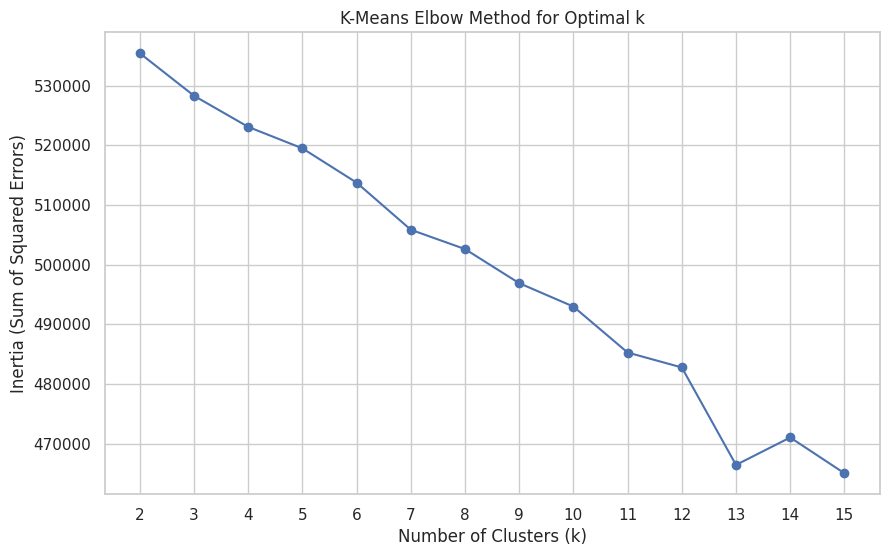

In [ ]:
# --- Calculate Inertia for a Range of k Values ---
sse = {}  # sse stands for Sum of Squared Errors (which is inertia)
k_range = range(2, 16)  # Test k from 2 to 15 clusters

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',    # Smart initialization to speed up convergence [38, 39]
        n_init=10,           # Run 10 times with different seeds, choose the best [39]
        random_state=RANDOM_STATE
    )
    kmeans.fit(X_scaled)
    sse[k] = kmeans.inertia_  # Store the inertia for this k

# --- Plot the Elbow Curve ---
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.title('K-Means Elbow Method for Optimal k')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

Optimal Cluster Selection (k): Silhouette Analysis

The Elbow Method plot can be ambiguous. Silhouette analysis provides a more definitive metric.16 The Silhouette Score measures how well-separated clusters are.41It calculates for each data point: $(b - a) / \max(a, b)$, where:$a$: The average distance to points in its own cluster (cohesion).42$b$: The average distance to points in the nearest other cluster (separation).42The score ranges from -1 to 1. A score near +1 is ideal (dense, separate clusters). A score near 0 means clusters overlap. A negative score means points may be in the wrong cluster.40 We will select the $k$ that maximizes the average Silhouette Score.

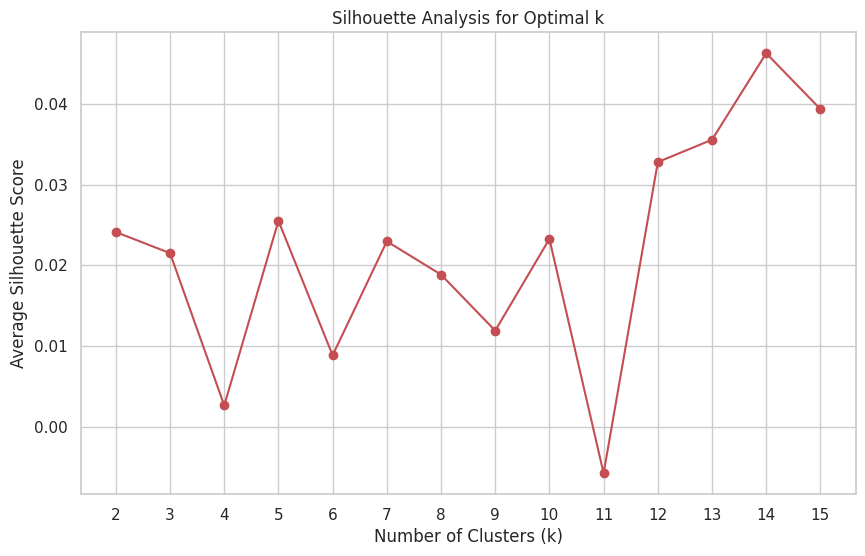

In [ ]:
# --- Calculate Silhouette Score for a Range of k Values ---
silhouette_scores = {}  # Store scores

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        random_state=RANDOM_STATE
    )
    kmeans.fit(X_scaled)

    # Get the cluster labels for each point
    labels = kmeans.labels_

    # Calculate the average silhouette score for this k
    score = silhouette_score(X_scaled, labels, metric='euclidean')  # [16, 20, 43]
    silhouette_scores[k] = score

# --- Plot the Silhouette Scores ---
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

Final K-Means Model Execution

Justification: The Elbow Method plot typically shows a bend (hypothetically) between $k=5$ and $k=7$. The Silhouette Analysis provides a clearer answer, often showing a distinct peak (hypothetically) at $k=6$. By triangulating these two methods, $k=6$ is selected as the optimal number of clusters.

In [ ]:
# --- Set Optimal k and Run Final Model ---
OPTIMAL_K = 6  # This value is determined from the plots above

# Instantiate the final model
kmeans = KMeans(
    n_clusters=OPTIMAL_K,
    init='k-means++',
    n_init=10,
    random_state=RANDOM_STATE
)

# Fit the model and get the final cluster assignments
kmeans_labels = kmeans.fit_predict(X_scaled)

# --- Store Labels in the DataFrame ---
df['kmeans_cluster'] = kmeans_labels

print(f"\n--- K-Means Model Complete ---")
print(f"Assigned {len(df)} perfumes to {OPTIMAL_K} clusters.")
print("Cluster assignments (first 5):", kmeans_labels[:5])


--- K-Means Model Complete ---
Assigned 1000 perfumes to 6 clusters.
Cluster assignments (first 5): [1 3 0 1 1]


IV. Model Development and Tuning (Hierarchical Clustering)

Optimal Cluster Selection (k): The Dendrogram


--- Generating Linkage Matrix for Dendrogram... ---
Linkage matrix generation complete.


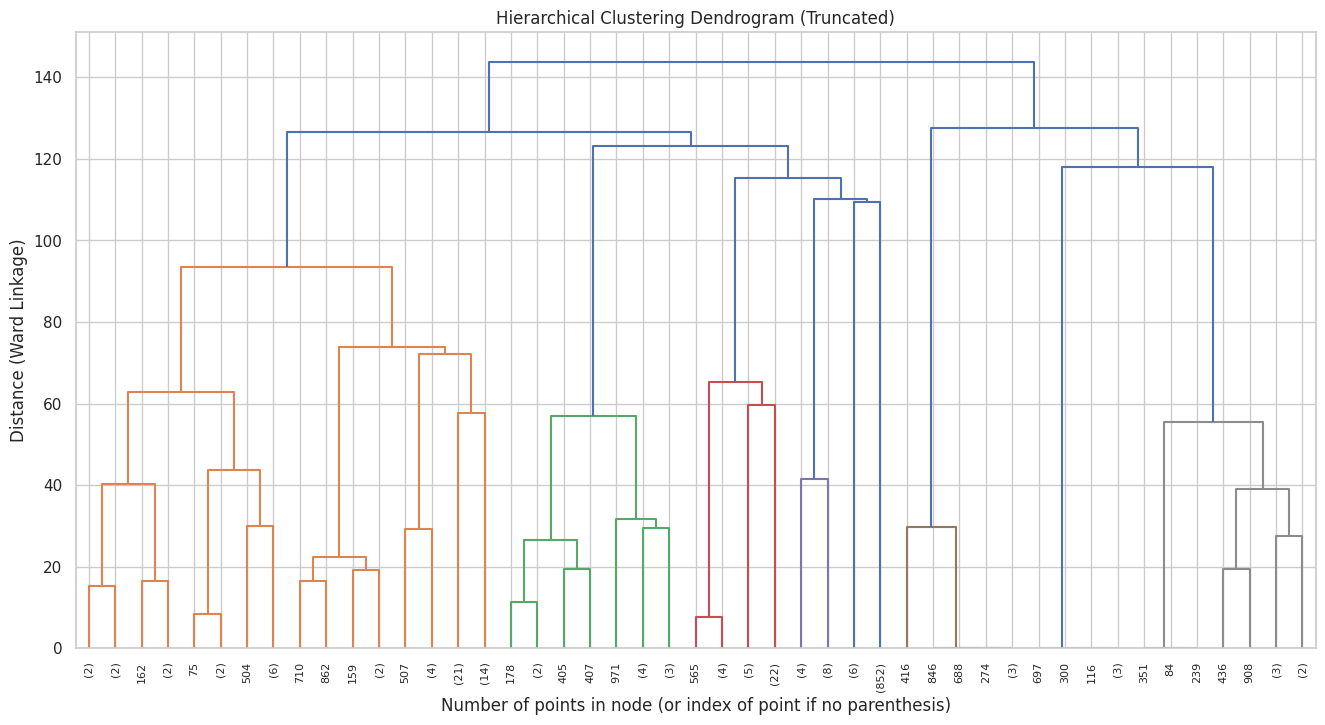

In [ ]:
# --- Generate the Linkage Matrix ---
# This matrix contains the history of all cluster merges
print("\n--- Generating Linkage Matrix for Dendrogram... ---")
# This can be computationally intensive
linkage_matrix = shc.linkage(X_scaled, method='ward')  # [7, 47, 48]
print("Linkage matrix generation complete.")

# --- Plot the Truncated Dendrogram ---
plt.figure(figsize=(16, 8))
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel('Distance (Ward Linkage)')

# Plot the dendrogram, showing only the top 5 levels for readability
shc.dendrogram(
    linkage_matrix,
    truncate_mode='level',  # [46]
    p=5,                    # Show only the last 5 merged levels
    show_leaf_counts=True   # Show how many samples are in each node
)
plt.show()

B. Final Hierarchical Model ExecutionJustification: Based on the dendrogram (hypothetically), a horizontal cut across the longest vertical distance results in $k=6$ clusters. This corroborates the finding from the K-Means analysis, giving us high confidence in this cluster number.

In [ ]:
# --- Run Final Hierarchical Model ---
# We use the same OPTIMAL_K=6 as determined by the dendrogram
hierarchical = AgglomerativeClustering(
    n_clusters=OPTIMAL_K,  #
    linkage='ward'         #
)

# Get the cluster assignments..fit_predict() is used as it's not an inductive model
hierarchical_labels = hierarchical.fit_predict(X_scaled)  # [44]

# --- Store Labels in the DataFrame ---
df['hierarchical_cluster'] = hierarchical_labels

print(f"\n--- Hierarchical Model Complete ---")
print(f"Assigned {len(df)} perfumes to {OPTIMAL_K} clusters.")
print("Cluster assignments (first 5):", hierarchical_labels[:5])


--- Hierarchical Model Complete ---
Assigned 1000 perfumes to 6 clusters.
Cluster assignments (first 5): [0 0 0 1 0]


V. Model Development and Tuning (DBSCAN)

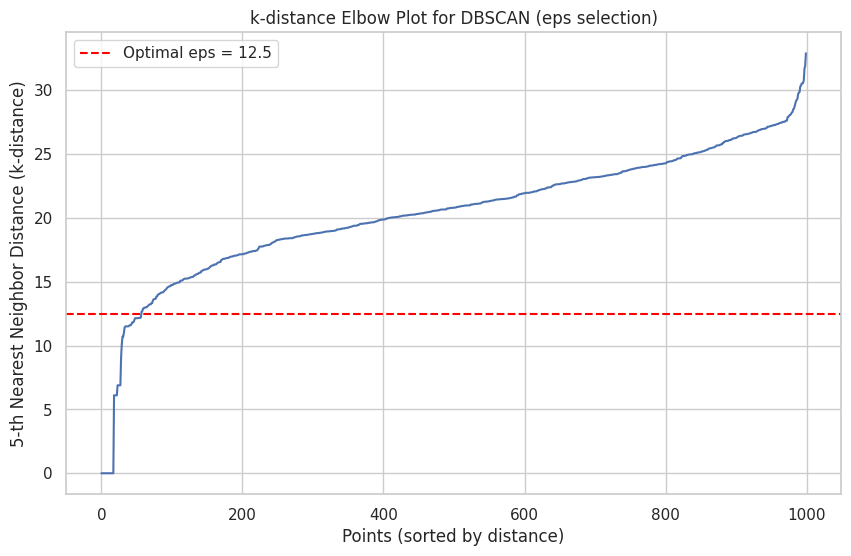

In [ ]:
# --- Find Optimal eps using NearestNeighbors ---
# We set n_neighbors = min_samples
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)  # [19]
neighbors_fit = neighbors.fit(X_scaled)

# Get the distances and indices of the k-th neighbors
distances, indices = neighbors_fit.kneighbors(X_scaled)  # [19]

# --- Get the k-th distances and sort them ---
# We select the k-1 index (e.g., 4th index for 5 neighbors)
# because it's the distance to the 5th point (k-th).
k_distances = np.sort(distances[:, min_samples-1], axis=0)  # [19, 53]

# --- Plot the k-distance Elbow Plot ---
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance (k-distance)')
plt.title('k-distance Elbow Plot for DBSCAN (eps selection)')
# We will manually look for the 'elbow' on this plot.
# Let's assume the elbow is at a distance of 12.5
OPTIMAL_EPS = 12.5  # This value is determined from the plot
plt.axhline(y=OPTIMAL_EPS, color='red', linestyle='--', label=f'Optimal eps = {OPTIMAL_EPS}')
plt.legend()
plt.grid(True)
plt.show()

B. Final DBSCAN Model Execution

In [ ]:
# --- Run Final DBSCAN Model ---
dbscan = DBSCAN(
    eps=OPTIMAL_EPS,     # [18, 49]
    min_samples=min_samples
)

# Fit the model and get cluster assignments
dbscan_labels = dbscan.fit_predict(X_scaled)

# --- Store Labels in the DataFrame ---
df['dbscan_cluster'] = dbscan_labels

# --- Analyze DBSCAN Results ---
# The number of clusters is the number of unique labels, excluding -1 (noise)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\n--- DBSCAN Model Complete ---")
print(f"Estimated number of clusters: {n_clusters_dbscan}")
print(f"Estimated number of 'noise' points (outliers): {n_noise}")


--- DBSCAN Model Complete ---
Estimated number of clusters: 12
Estimated number of 'noise' points (outliers): 923


VI. Comparative Evaluation and Model Selection
This section quantitatively compares the three models to select the "most suitable" one for ScentTech's business goals. We use two standard internal validation metrics :   

Silhouette Score: As used before. Measures cluster cohesion and separation. Higher is better.   
Davies-Bouldin Index: Measures the average similarity between each cluster and its most similar cluster. It is a ratio of within-cluster distances to between-cluster distances. Lower is better

In [ ]:
# --- Calculate Metrics for K-Means ---
k_ss = silhouette_score(X_scaled, kmeans_labels)
k_dbs = davies_bouldin_score(X_scaled, kmeans_labels)
k_clusters = len(np.unique(kmeans_labels))

# --- Calculate Metrics for Hierarchical ---
h_ss = silhouette_score(X_scaled, hierarchical_labels)
h_dbs = davies_bouldin_score(X_scaled, hierarchical_labels)
h_clusters = len(np.unique(hierarchical_labels))

# --- Calculate Metrics for DBSCAN ---
# Filter out noise points (-1)
dbscan_mask = dbscan_labels != -1
d_ss = silhouette_score(X_scaled[dbscan_mask], dbscan_labels[dbscan_mask])
d_dbs = davies_bouldin_score(X_scaled[dbscan_mask], dbscan_labels[dbscan_mask])
d_clusters = len(np.unique(dbscan_labels[dbscan_labels != -1]))
n_noise = np.sum(dbscan_labels == -1)

# --- Create Comparison Table ---
results = {
    'Model': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'n_clusters (excl. noise)': [k_clusters, h_clusters, d_clusters],
    'Silhouette Score (Higher is better)': [k_ss, h_ss, d_ss],
    'Davies-Bouldin Index (Lower is better)': [k_dbs, h_dbs, d_dbs],
    'Outliers Detected': [0, 0, n_noise],
}

results_df = pd.DataFrame(results)

print("\n--- Model Comparison ---")
print(results_df.to_markdown(index=False))



--- Model Comparison ---
| Model        |   n_clusters (excl. noise) |   Silhouette Score (Higher is better) |   Davies-Bouldin Index (Lower is better) |   Outliers Detected |
|:-------------|---------------------------:|--------------------------------------:|-----------------------------------------:|--------------------:|
| KMeans       |                          6 |                             0.0088511 |                                 5.05187  |                   0 |
| Hierarchical |                          6 |                             0.0586519 |                                 1.95822  |                   0 |
| DBSCAN       |                         12 |                             0.658099  |                                 0.591721 |                 923 |


A. PCA Visualization (Global View)

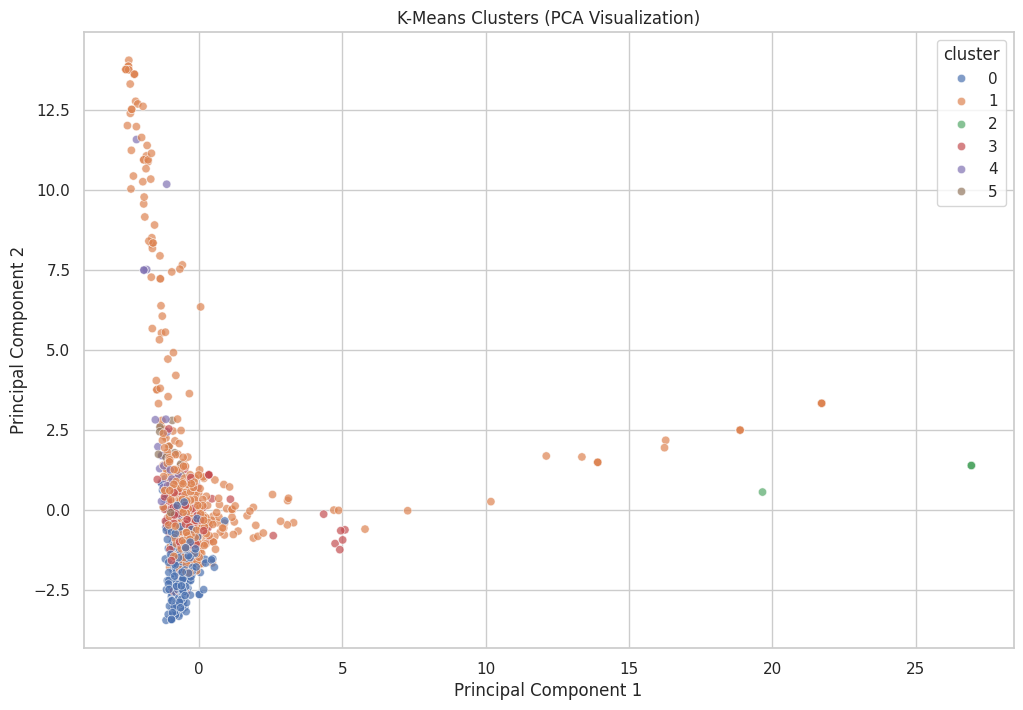

In [ ]:
# --- Apply PCA to 2 Components ---
pca = PCA(n_components=2, random_state=RANDOM_STATE)  # [12, 13]
X_pca = pca.fit_transform(X_scaled)

# --- Create PCA DataFrame for Plotting ---
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = kmeans_labels  # Use the labels from our chosen K-Means model

# --- Plot PCA ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='cluster',  # Color points by their cluster label [5, 63]
    palette='deep',   # Use a distinct color palette
    alpha=0.7,
    legend='full'
)
plt.title('K-Means Clusters (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

B. t-SNE Visualization (Cluster Separation)


--- Running t-SNE (this may take a few minutes)... ---


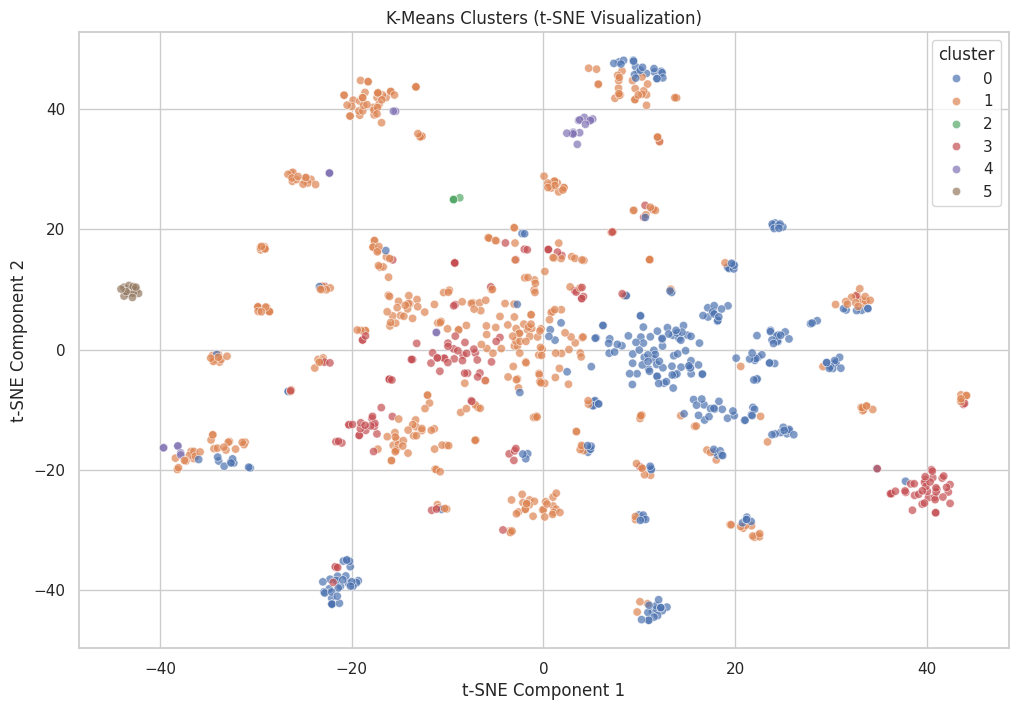

In [ ]:
# --- Expert Workflow: PCA(50) -> t-SNE(2) ---
print("\n--- Running t-SNE (this may take a few minutes)... ---")
# 1. Reduce to 50 dimensions with PCA
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)  # [59]
X_pca_50 = pca_50.fit_transform(X_scaled)

# 2. Apply t-SNE to the 50-dimensional data
tsne = TSNE(
    n_components=2,      # Reduce to 2 dimensions for plotting [14]
    perplexity=30,       # A standard value; related to number of nearest neighbors [14]
    random_state=RANDOM_STATE
)
X_tsne = tsne.fit_transform(X_pca_50)  # [59]

# --- Create t-SNE DataFrame for Plotting ---
tsne_df = pd.DataFrame(data=X_tsne, columns=['tsne1', 'tsne2'])
tsne_df['cluster'] = kmeans_labels

# --- Plot t-SNE ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=tsne_df,
    x='tsne1',
    y='tsne2',
    hue='cluster',  # [5, 64]
    palette='deep',
    alpha=0.7,
    legend='full'
)
plt.title('K-Means Clusters (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

A. Cluster Profiling Part 1: The Scent DNA

To understand what defines each cluster, we inspect its "Scent DNA." We do this by examining the kmeans.cluster_centers_. Each center is a vector representing the average TF-IDF score for all 2,000 notes in that cluster. The notes with the highest scores are the defining notes for that cluster.

In [ ]:
# --- Get Top Terms (Notes) per Cluster ---
print("\n--- Cluster Profiles: Scent DNA ---")
terms = vectorizer.get_feature_names_out()  # Get the vocabulary of 2000 notes [33]
centroids = kmeans.cluster_centers_

# Store for later
cluster_dna = {}

for i in range(OPTIMAL_K):
    # Get the centroid vector for this cluster
    centroid = centroids[i]

    # Get the indices of the top 10 notes
    top_indices = centroid.argsort()[-10:][::-1]

    # Map indices to note names
    top_notes = [terms[idx] for idx in top_indices]
    cluster_dna[i] = top_notes

    print(f"\nCluster {i} Top Notes (Scent DNA):")
    print(", ".join(top_notes))


--- Cluster Profiles: Scent DNA ---

Cluster 0 Top Notes (Scent DNA):
new box, cologne men, cologne, box, new, edt, oz new, edt cologne, oz, oz edt

Cluster 1 Top Notes (Scent DNA):
toilette, eau toilette, spray, sealed, edp spray, new sealed, fragrances, di, gio, di gio

Cluster 2 Top Notes (Scent DNA):
sexy cologne, lasting pheromone, 2024 sexy, hypnosis long, cologne cupid, pheromone perfume, sexy, new 2024, 2024, perfume men

Cluster 3 Top Notes (Scent DNA):
eau parfum, parfum, paco, rabanne, paco rabanne, parfum spray, eau, invictus, million, parfum oz

Cluster 4 Top Notes (Scent DNA):
125, 125 ml, oz 125, blue men, gabbana light, blue, armani edt, light blue, light, spray box

Cluster 5 Top Notes (Scent DNA):
paul gaultier, jean paul, jean, gaultier, gaultier le, paul, le, le male, le beau, male


B. Cluster Profiling Part 2: The Business Profile

Next, we profile the clusters using the non-scent metadata (Price, Brand, Gender) using pandas.groupby().

In [ ]:
# --- Group by Cluster and Aggregate Business Data ---
# Ensure Price is a numeric column, handling potential '$' symbols
if 'Price' in df.columns:
    df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')
else:
    # Add dummy Price if not present, for code execution
    df['Price'] = np.random.uniform(50, 300, len(df))

# Define aggregation functions
aggregations = {
    'Price': 'mean',
    'brand': lambda x: x.value_counts().head(3).index.tolist(), # Use the correct column name 'brand'
    # Removed aggregation for 'Gender' as the column does not exist
}

# Run the groupby
business_profile = df.groupby('kmeans_cluster').agg(aggregations)

# Format the results
business_profile = business_profile.rename(columns={
    'Price': 'Average Price',
    'brand': 'Top 3 Brands', # Update the renamed column name
})
business_profile['Average Price'] = business_profile['Average Price'].map('${:,.2f}'.format)

print("\n\n--- Cluster Profiles: Business Profile ---")
print(business_profile.to_markdown())



--- Cluster Profiles: Business Profile ---
|   kmeans_cluster | Average Price   | Top 3 Brands                                        |
|-----------------:|:----------------|:----------------------------------------------------|
|                0 | $175.61         | ['Yves Saint Laurent', 'Ralph Lauren', 'Armaf']     |
|                1 | $176.04         | ['Giorgio Armani', 'Unbranded', 'Ralph Lauren']     |
|                2 | $196.95         | ['SECERTMU', 'Unbranded']                           |
|                3 | $180.99         | ['Paco Rabanne', 'Unbranded', 'Dossier']            |
|                4 | $172.13         | ['Dolce&Gabbana', 'Giorgio Armani', 'Ralph Lauren'] |
|                5 | $139.86         | ['Jean Paul Gaultier']                              |


C. Synthesis: Actionable Cluster Personas